In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from numpy import loadtxt
from xgboost import XGBRegressor
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Ingestion and Preprocessing

## Merge datasets (drought index and capacity)

In [ ]:
# Read the Drought index dataset
drought_index = pd.read_csv('/content/drive/Shareddrives/Capstone A1_team project/2011_2021_drought.csv')

In [ ]:
# Display the first few rows of the drought index dataset
drought_index.head()

,MapDate,StateAbbreviation,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20211228,CT,"4,978.77",0.00,0.00,0.00,0.00,0.0,2021-12-28,2022-01-03,2
1,20211221,CT,"4,978.77",0.00,0.00,0.00,0.00,0.0,2021-12-21,2021-12-27,2
2,20211214,CT,"4,978.77",0.00,0.00,0.00,0.00,0.0,2021-12-14,2021-12-20,2
3,20211207,CT,"4,978.77",0.00,0.00,0.00,0.00,0.0,2021-12-07,2021-12-13,2
4,20211130,CT,"4,978.77",0.00,0.00,0.00,0.00,0.0,2021-11-30,2021-12-06,2


In [ ]:
# Create year, month, and state columns for merging
drought_index['Year'] = drought_index['MapDate'].astype(str).str[0:4].astype('int')
drought_index['Month'] = drought_index['MapDate'].astype(str).str[4:6].astype('int')
drought_index.rename(columns={'StateAbbreviation':'State'}, inplace=True)

In [ ]:
# Keep columns of interest
drought_index.drop(columns=['MapDate','ValidStart','ValidEnd','StatisticFormatID'], inplace=True)

In [ ]:
# Inspect data types
drought_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025 entries, 0 to 4024
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   4025 non-null   object 
 1   None    4025 non-null   object 
 2   D0      4025 non-null   object 
 3   D1      4025 non-null   object 
 4   D2      4025 non-null   object 
 5   D3      4025 non-null   object 
 6   D4      4025 non-null   float64
 7   Year    4025 non-null   int64  
 8   Month   4025 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 283.1+ KB


In [ ]:
def str_to_num_converter(df, col_list):
    """ Converting features from string type to numeric data type.
    This function should be called before handling outliers.
    
    :param df: a dataframe with data type inconsistency issue
    :type df: pandas dataframe
    :param col_list: a list of columns that needs to be cast in numeric form
    :type column: list
    """
    
    # Iterate through a list of columns that require handling
    for col in col_list:

        # Use regular expression to extract numerical data only
        df[col] = df[col].astype('str')
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].str.extract('(\d+)')
            
        # Convert data type to numeric, set invalid parsing as NaN by specifying error to 'coerce'
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print("All values in {} have been converted to numeric, exceptions are casted to NaN values.".format(col))
        # We will come back to NaN imputation after we handle outliers

In [ ]:

# convert from string to number
str_to_num_converter(drought_index, ['None','D0','D1','D2','D3'])

All values in None have been converted to numeric, exceptions are casted to NaN values.
All values in D0 have been converted to numeric, exceptions are casted to NaN values.
All values in D1 have been converted to numeric, exceptions are casted to NaN values.
All values in D2 have been converted to numeric, exceptions are casted to NaN values.
All values in D3 have been converted to numeric, exceptions are casted to NaN values.


In [ ]:

# Check our cleaned drought index
drought_index.head(5)

,State,None,D0,D1,D2,D3,D4,Year,Month
0,CT,4978,0,0,0,0,0.0,2021,12
1,CT,4978,0,0,0,0,0.0,2021,12
2,CT,4978,0,0,0,0,0.0,2021,12
3,CT,4978,0,0,0,0,0.0,2021,12
4,CT,4978,0,0,0,0,0.0,2021,11


In [ ]:
# calculate average drought index on a monthly level
drought_index = drought_index.groupby(by=['Year','Month','State']).mean().reset_index()

In [ ]:
# Merge with our previously cleaned data on github
df = pd.read_csv('https://raw.githubusercontent.com/chinarbu/BU_NIDIS_TeamA1_Capstone/main/Energy_level.csv')
    #df = df.merge(drought_index, on=['Year','Month','State'], how='left')

In [ ]:
# Remove water usage realted columns to perserve data quality
#df = df.iloc[:,0:10].join(df.iloc[:,-6:])

In [ ]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'State', 'Revenue(Thousand $)',
       'Consumption(Megawatthours)', 'Customers(Count)', 'Price(Cents/kWh)',
       'Precipitation', 'Temperature', 'nat_gas_to_elect_power', 'None', 'D0',
       'D1', 'D2', 'D3', 'D4', 'PDSI'],
      dtype='object')

In [ ]:
df.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
# Read plant level data
plantD = pd.read_csv('https://raw.githubusercontent.com/chinarbu/BU_NIDIS_TeamA1_Capstone/main/Plant_level.csv')

In [ ]:
plantD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Plant id                 142 non-null    int64  
 1   Plant name               142 non-null    object 
 2   County                   142 non-null    object 
 3   State                    142 non-null    object 
 4   state county fips        142 non-null    int64  
 5   water source             138 non-null    object 
 6   Latitude                 139 non-null    float64
 7   Longitude                139 non-null    float64
 8   elevation_in_feet        139 non-null    float64
 9   com_id                   137 non-null    float64
 10  gen type                 141 non-null    object 
 11  CAPACITY_MW              141 non-null    float64
 12  CHP                      141 non-null    float64
 13  USGS_WATER_TYPE          139 non-null    object 
 14  MODEL_COOL_TYPE          1

In [ ]:
plantD.head()

,Plant id,Plant name,County,State,state county fips,water source,Latitude,Longitude,elevation_in_feet,com_id,...,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
0,546,Montville Station,New London,CT,9011,Thames River,41.42788,-72.1010,0.0,6171772.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,548,NRG Norwalk Harbor,Fairfield,CT,9001,Long Island Sound,41.07302,-73.4111,0.0,7734299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,562,Middletown,Middlesex,CT,9007,Connecticut River,41.55493,-72.5793,20.0,7701182.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,566,Millstone,New London,CT,9011,Long Island Sound,41.31145,-72.1679,0.0,6170916.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,568,Bridgeport Station,Fairfield,CT,9001,Bridgeport Harbor,41.17141,-73.1840,0.0,7734269.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Group plant level data by state, and calculate the overall capacity in MWH and MW
plant = plantD.groupby('State')[['CAPACITY_MW','NET_GEN_MWH']].mean()
plant['CAPACITY_MWH'] = plant['CAPACITY_MW']*24*30
plant.head(5)

,CAPACITY_MW,NET_GEN_MWH,CAPACITY_MWH
State,,,
CT,362.038889,1.578153e+06,260668.000000
MA,362.695455,1.395764e+06,261140.727273
ME,185.278571,5.896468e+05,133400.571429
NH,303.538462,1.579932e+06,218547.692308
NY,451.904615,1.441768e+06,325371.323077


In [ ]:
# Merge capacity data with our main dataset
df = df.merge(plant, left_on='State', right_index=True, how='left')

In [ ]:
df.columns

Index(['Year', 'Month', 'State', 'Revenue(Thousand $)',
       'Consumption(Megawatthours)', 'Customers(Count)', 'Price(Cents/kWh)',
       'Precipitation', 'Temperature', 'nat_gas_to_elect_power', 'None', 'D0',
       'D1', 'D2', 'D3', 'D4', 'PDSI', 'CAPACITY_MW', 'NET_GEN_MWH',
       'CAPACITY_MWH'],
      dtype='object')

In [ ]:
df.rename(columns = {'None':'Drought_index'}, inplace=True)
df.drop(columns='nat_gas_to_elect_power', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        840 non-null    float64
 1   Month                       840 non-null    float64
 2   State                       840 non-null    object 
 3   Revenue(Thousand $)         840 non-null    object 
 4   Consumption(Megawatthours)  840 non-null    object 
 5   Customers(Count)            840 non-null    object 
 6   Price(Cents/kWh)            840 non-null    float64
 7   Precipitation               840 non-null    float64
 8   Temperature                 840 non-null    float64
 9   Drought_index               840 non-null    float64
 10  D0                          840 non-null    float64
 11  D1                          840 non-null    float64
 12  D2                          840 non-null    float64
 13  D3                          840 non

In [ ]:
df.head()

,Year,Month,State,Revenue(Thousand $),Consumption(Megawatthours),Customers(Count),Price(Cents/kWh),Precipitation,Temperature,Drought_index,D0,D1,D2,D3,D4,PDSI,CAPACITY_MW,NET_GEN_MWH,CAPACITY_MWH
0,2011.0,1.0,CT,"466,863","2,780,309","1,614,219",16.79,3.36,23.2,4.0,0.0,0.0,0.0,0.0,0.0,-0.04,362.038889,1.578153e+06,260668.0
1,2011.0,2.0,CT,"387,663","2,390,927","1,572,803",16.21,3.84,27.1,4.0,0.0,0.0,0.0,0.0,0.0,0.21,362.038889,1.578153e+06,260668.0
2,2011.0,3.0,CT,"398,719","2,436,332","1,614,558",16.37,4.74,37.0,4.0,0.0,0.0,0.0,0.0,0.0,1.04,362.038889,1.578153e+06,260668.0
3,2011.0,4.0,CT,"370,989","2,260,627","1,612,808",16.41,5.52,48.9,4.0,0.0,0.0,0.0,0.0,0.0,-0.02,362.038889,1.578153e+06,260668.0
4,2011.0,5.0,CT,"376,033","2,300,770","1,611,524",16.34,4.87,59.7,4.0,0.0,0.0,0.0,0.0,0.0,0.01,362.038889,1.578153e+06,260668.0


In [ ]:
# Handle data type inconsistencies
str_to_num_converter(df, ['Revenue(Thousand $)', 'Consumption(Megawatthours)', 'Customers(Count)'])

All values in Revenue(Thousand $) have been converted to numeric, exceptions are casted to NaN values.
All values in Consumption(Megawatthours) have been converted to numeric, exceptions are casted to NaN values.
All values in Customers(Count) have been converted to numeric, exceptions are casted to NaN values.


In [ ]:
df = df.iloc[:-2,:]

In [ ]:
df.to_csv('/content/drive/Shareddrives/Capstone A1_team project/Original_features.csv')

# EDA

In [ ]:
temp = df.copy()
col_rename = {"Consumption(Megawatthours)":"Consumption(MWH)",
              "Revenue(Thousand $)":"Revenue($K)",
              "Customers(Count)":"# Customers",
              "Drought_index":"DSI",
              "CAPACITY_MW":"Capacity(MW)",
               "NET_GEN_MWH":"Net Generation (MWH)",
               "CAPACITY_MWH":"Capacity(MWH)",
               "D0":"DSI - 0",
               "D1":"DSI - 1",
               "D2":"DSI - 2",
               "D3":"DSI - 3",
               "D4":"DSI - 4"}
temp.rename(col_rename,axis=1,inplace=True)

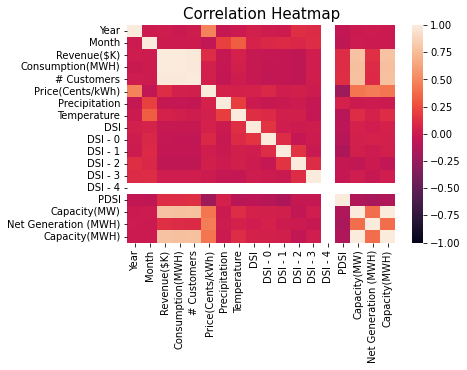

In [ ]:
fig = sns.heatmap(temp.corr(method  ="pearson"),vmin=-1,vmax=1)
plt.title("Correlation Heatmap", fontsize=15)
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/Correlation_Heatmap_cw.png",bbox_inches="tight")

In [ ]:
import re

def clean_string(value):
  val = re.sub('[^0-9]','',value)
  return val

In [ ]:
# temp = df.copy()
consumption = []
for i in temp["Consumption(MWH)"]: 
  try:
    clean_val = clean_string(i)
    consumption.append(clean_val)
  except:
    consumption.append(i)
temp["consumption"] = consumption
#temp["Consumption(Megawatthours)"].astype(int).apply(np.log)

In [ ]:
temp["logConsumption"] = np.log10(temp["consumption"].astype(int))

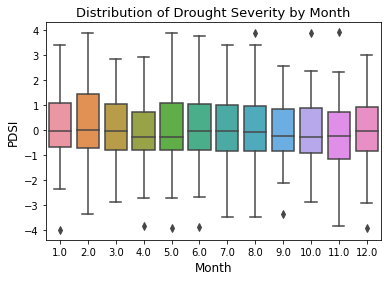

In [ ]:
sns.boxplot(data=temp,x="Month",y="PDSI")
plt.title("Distribution of Drought Severity by Month", fontsize=13)
plt.xlabel("Month",fontsize=12)
plt.ylabel("PDSI",fontsize=12)
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/PDSI_BoxPlot_cw.png",bbox_inches="tight")

In [ ]:
# temp.loc[13,"Month"].astype(int).astype(str).zfill(2)
for i in range(len(temp["Month"])):
  temp.loc[i,"Month_Cl"] = temp.loc[i,"Month"].astype(int).astype(str).zfill(2)
for i in range(len(temp["Year"])):
  temp.loc[i,'date'] = temp.loc[i,"Month_Cl"] + "-01-" + temp.loc[i,"Year"].astype(int).astype(str)
temp['date'] = pd.to_datetime(temp["date"])
temp.head()

,Year,Month,State,Revenue($K),Consumption(MWH),# Customers,Price(Cents/kWh),Precipitation,Temperature,DSI,...,DSI - 3,DSI - 4,PDSI,Capacity(MW),Net Generation (MWH),Capacity(MWH),consumption,logConsumption,Month_Cl,date
0,2011.0,1.0,CT,466863.0,2780309.0,1614219.0,16.79,3.36,23.2,4.0,...,0.0,0.0,-0.04,362.038889,1.578153e+06,260668.0,2780309.0,6.444093,01,2011-01-01
1,2011.0,2.0,CT,387663.0,2390927.0,1572803.0,16.21,3.84,27.1,4.0,...,0.0,0.0,0.21,362.038889,1.578153e+06,260668.0,2390927.0,6.378566,02,2011-02-01
2,2011.0,3.0,CT,398719.0,2436332.0,1614558.0,16.37,4.74,37.0,4.0,...,0.0,0.0,1.04,362.038889,1.578153e+06,260668.0,2436332.0,6.386736,03,2011-03-01
3,2011.0,4.0,CT,370989.0,2260627.0,1612808.0,16.41,5.52,48.9,4.0,...,0.0,0.0,-0.02,362.038889,1.578153e+06,260668.0,2260627.0,6.354229,04,2011-04-01
4,2011.0,5.0,CT,376033.0,2300770.0,1611524.0,16.34,4.87,59.7,4.0,...,0.0,0.0,0.01,362.038889,1.578153e+06,260668.0,2300770.0,6.361873,05,2011-05-01


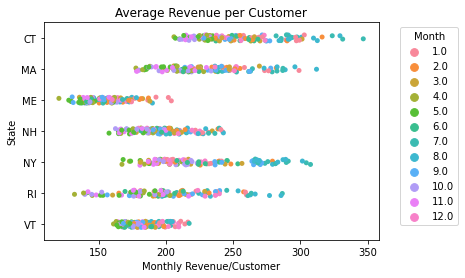

In [ ]:
temp['logRevenue'] = np.log(temp['Revenue($K)'])
temp['revenuePerCustomer'] = (temp["Revenue($K)"] / temp["# Customers"])*1000
temp['consumptionPerCustomer'] = temp['Consumption(MWH)'] / temp['# Customers']
# temp['revenue']
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
nums = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0]

sns.stripplot(data=temp,x="revenuePerCustomer",y="State",hue="Month")
plt.title("Average Revenue per Customer")
plt.xlabel("Monthly Revenue/Customer")
plt.ylabel("State")
plt.legend(title="Month",bbox_to_anchor=(1.05, 1))
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/RevPerCust_cw.png",bbox_inches="tight")

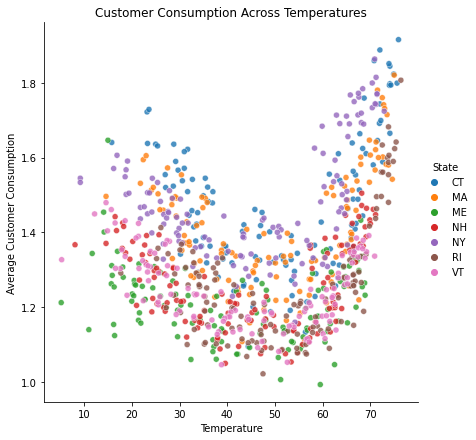

In [ ]:
sns.relplot(data=temp,x="Temperature",y="consumptionPerCustomer",hue="State", alpha=.8,height=6)
plt.title("Customer Consumption Across Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Average Customer Consumption")
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/ConsumptionTemps_cw.png",bbox_inches="tight")

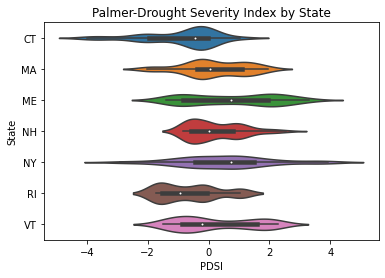

In [ ]:
sns.violinplot(data=temp, x="PDSI",y="State")
plt.title("Palmer-Drought Severity Index by State")
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/violinPDSI_cw.png",bbox_inches="tight")

In [ ]:
temp2 = temp.groupby(['State',"Month"])[["Consumption(MWH)"]].aggregate(np.mean).reset_index()
temp2.head()

,State,Month,Consumption(MWH)
0,CT,1.0,2626611.0
1,CT,2.0,2390462.8
2,CT,3.0,2343689.8
3,CT,4.0,2154587.5
4,CT,5.0,2098883.9


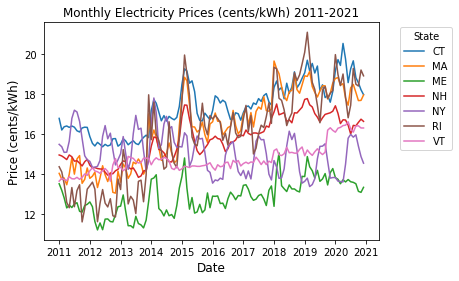

In [ ]:
sns.lineplot(data=temp,x="date",y="Price(Cents/kWh)",hue="State")
plt.title("Monthly Electricity Prices (cents/kWh) 2011-2021")
plt.xlabel("Date",size=12)
plt.ylabel("Price (cents/kWh)",size=12)
plt.legend(title="State",bbox_to_anchor=(1.05, 1))
plt.savefig("/content/drive/Shareddrives/Capstone A1_team project/Figures/monthlyElectricityPrices_cw.png",bbox_inches="tight")

# Machine Learning

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Capstone A1_team project/Original_features.csv')

In [ ]:
df=df.iloc[:,1:]

## Feature Engineering

In [ ]:
df.columns

Index(['Year', 'Month', 'State', 'Revenue(Thousand $)',
       'Consumption(Megawatthours)', 'Customers(Count)', 'Price(Cents/kWh)',
       'Precipitation', 'Temperature', 'Drought_index', 'D0', 'D1', 'D2', 'D3',
       'D4', 'PDSI', 'CAPACITY_MW', 'NET_GEN_MWH', 'CAPACITY_MWH'],
      dtype='object')

In [ ]:
# Create lag temperature and lag precipitation
df['temp_lag1'] = df['Temperature'].shift(1).fillna(df['Temperature'].mean())
df['prec_lag1'] = df['Precipitation'].shift(1).fillna(df['Precipitation'].mean())

# Create the interaction feature between temperature and precipation
df['prec/temp'] = df['Precipitation']/df['Temperature']

# Consumption per customer
df['MWH_per_customer'] = df['Consumption(Megawatthours)']/df['Customers(Count)']

# Percentage of power generated based on full capacity
df['%Capacity_used'] = df['Consumption(Megawatthours)']/df['CAPACITY_MWH']

# Full capacity hours
df['full_cap_hours'] = df['Consumption(Megawatthours)']/df['CAPACITY_MW']

In [ ]:
# Define columns for more feature combination
engineer_cols = ['MWH_per_customer', 'prec/temp', 
                 'Temperature', 'Precipitation', 'Drought_index', 'D0',
                 'D1', 'D2','D3','D4', '%Capacity_used', 'full_cap_hours']

In [ ]:
from seaborn.utils import percentiles
for i in engineer_cols:
  for j in engineer_cols:
    df['top25%_'+i+'_'+j] = ((df[i]>df[i].quantile(0.75)) & 
                                 (df[j]>df[j].quantile(0.75))).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
for i in engineer_cols:
  for j in engineer_cols:
    df['bot25%_'+i+'_'+j] = ((df[i]<df[i].quantile(0.25)) & 
                                 (df[j]<df[j].quantile(0.25))).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [ ]:
for i in engineer_cols:
  for j in engineer_cols:
    df['top/bot25%_'+i+'_'+j] = ((df[i]<df[i].quantile(0.25)) & 
                                 (df[j]>df[j].quantile(0.75))).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [ ]:
# Binning for yearly change on median listing days on market
bin_label_10 = ['drought_index_10th', 'drought_index_9th', 'drought_index_8th', 'drought_index_7th',
                'drought_index_6th','drought_index_5th','drought_index_4th', 'drought_index_3th', 
                'drought_index_2th', 'drought_index_1th']
df['Drought_index_percentile'] = pd.qcut(df['Drought_index'],
                              q=10, labels=bin_label_10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
# Conver ranks into categorical varaibles
df = pd.get_dummies(data=df,columns=['Drought_index_percentile', 'State'])

In [ ]:
df.head(5)

,Year,Month,Revenue(Thousand $),Consumption(Megawatthours),Customers(Count),Price(Cents/kWh),Precipitation,Temperature,Drought_index,D0,...,Drought_index_percentile_drought_index_3th,Drought_index_percentile_drought_index_2th,Drought_index_percentile_drought_index_1th,State_CT,State_MA,State_ME,State_NH,State_NY,State_RI,State_VT
0,2011.0,1.0,466863.0,2780309.0,1614219.0,16.79,3.36,23.2,4.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,2011.0,2.0,387663.0,2390927.0,1572803.0,16.21,3.84,27.1,4.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,2011.0,3.0,398719.0,2436332.0,1614558.0,16.37,4.74,37.0,4.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,2011.0,4.0,370989.0,2260627.0,1612808.0,16.41,5.52,48.9,4.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,2011.0,5.0,376033.0,2300770.0,1611524.0,16.34,4.87,59.7,4.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Keep a copy of this dataset
df.to_csv('/content/drive/Shareddrives/Capstone A1_team project/Final deliverable folder/final_04_29.csv')

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Capstone A1_team project/Final deliverable folder/final_04_23.csv')

## Predict electricity price (cents/kWh)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,840.0,2.015500e+03,2.873993e+00,2011.0,2013.00,2015.5,2018.00,2020.0
Month,840.0,6.500000e+00,3.454109e+00,1.0,3.75,6.5,9.25,12.0
Revenue(Thousand $),840.0,4.886136e+05,6.053030e+05,57778.0,107878.25,144102.5,658823.75,2484196.0
Consumption(Megawatthours),840.0,3.144384e+06,3.944949e+06,392218.0,654424.75,1004174.5,4116004.00,15262546.0
Customers(Count),840.0,2.198860e+06,2.607669e+06,358380.0,503847.50,801871.0,3119911.75,8403778.0
...,...,...,...,...,...,...,...,...
State_NH,840.0,1.428571e-01,3.501356e-01,0.0,0.00,0.0,0.00,1.0
State_NY,840.0,1.428571e-01,3.501356e-01,0.0,0.00,0.0,0.00,1.0
State_RI,840.0,1.428571e-01,3.501356e-01,0.0,0.00,0.0,0.00,1.0
State_VT,840.0,1.428571e-01,3.501356e-01,0.0,0.00,0.0,0.00,1.0


In [ ]:
# Define our targeting feature and training space
df=df.fillna(df.mean())
X = df.iloc[:,8:]
y = df['Price(Cents/kWh)']

In [ ]:
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

In [ ]:
# Split training and testing samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=727)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
#Creating model 
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred_linear = linear.predict(X_test)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_linear))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_linear))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear)))
print('Explained Variance Score:',metrics.explained_variance_score(y_test, y_pred_linear)*100)

Mean Absolute Error: 1.0908648066618005
Mean Squared Error: 1.8814256086693417
Root Mean Squared Error: 1.371650687554722
Explained Variance Score: 48.51958407994146


### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lasso))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred_lasso)*100)

Mean Absolute Error: 1.5912043458891978
Mean Squared Error: 3.59794754837173
Root Mean Squared Error: 1.8968256504939325
Explained Variance Score: 3.199518701439974


In [ ]:
# Hyperparameters tuning
from sklearn.model_selection import GridSearchCV
params_lasso = {'alpha': (np.logspace(-4, -1, 4))} # It will check from 1e-08 to 1e+08
lasso_cv = GridSearchCV(lasso, params_lasso, cv = 5)
lasso_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.411e+02, tolerance: 1.968e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.452e+02, tolerance: 1.977e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.0001, 0.001 , 0.01  , 0.1   ])})

In [ ]:
print(lasso_cv.best_estimator_)

Lasso(alpha=0.01)


In [ ]:
lasso_2 = Lasso(alpha=0.01)
lasso_2.fit(X_train, y_train)
y_pred_lasso2 = lasso_2.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lasso2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso2)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred_lasso2)*100)

Mean Absolute Error: 1.1067342777406122
Mean Squared Error: 1.9565010165129213
Root Mean Squared Error: 1.3987498048303426
Explained Variance Score: 46.67740706164412


### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train )
y_pred_dt = np.round(dt.predict(X_test))

In [ ]:
# Check model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_dt))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt)))
print('Explained Variance Score:',metrics.explained_variance_score(y_test, y_pred_dt)*100)

Mean Absolute Error: 1.239464285714286
Mean Squared Error: 3.02538869047619
Root Mean Squared Error: 1.73936445015879
Explained Variance Score: 18.38500498057836


### Random Forest Regressor

In [ ]:
# Fit random forest model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_rf = np.round(rf.predict(X_test))

In [ ]:
# Check model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('Explained Variance Score:',metrics.explained_variance_score(y_test, y_pred_rf)*100)

Mean Absolute Error: 0.8588690476190474
Mean Squared Error: 1.3376541666666664
Root Mean Squared Error: 1.1565700007637525
Explained Variance Score: 63.697339278849995


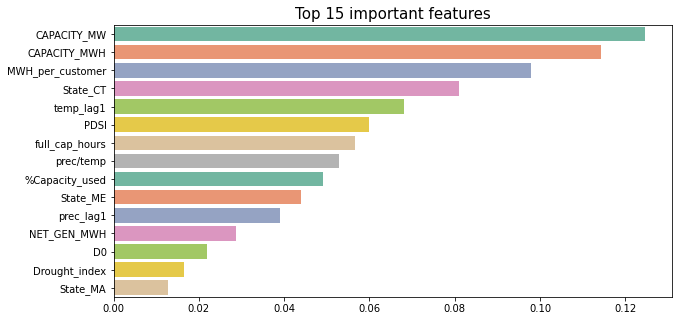

In [ ]:
# Plot features importances
imp = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[0:15]
plt.figure(figsize=(10,5))
plt.title("Top 15 important features", fontsize=15)
ax = sns.barplot(y=imp.index, x=imp.values, palette="Set2", orient='h')

**Hyperparameters tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                               n_iter = 50, cv = 3, verbose=2, random_state=777, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=777, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}

In [ ]:
from sklearn.metrics import mean_squared_error

# Define a new random forest model with our best set of hyperparameters
rf_cv = RandomForestRegressor(bootstrap= True, max_depth=100,
                              max_features='auto', min_samples_leaf = 1, 
                              min_samples_split = 2, n_estimators = 2000)
rf_cv.fit(X_train, y_train)
y_pred_rf_cv = np.round(rf_cv.predict(X_test))

In [ ]:
# Random forest model evaluation after cv
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_cv))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_cv))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_cv)))
print('Random Forest Regression Score:',rf_cv.score(X_test,y_pred_rf_cv)*100)

Mean Absolute Error: 0.8579166666666667
Mean Squared Error: 1.3284875
Root Mean Squared Error: 1.1526003210133164
Random Forest Regression Score: 96.01117932022748


**Our random forest model after hyperparameters tuning might be overfitting. We might want to increase of training samples or do further feature engineering**

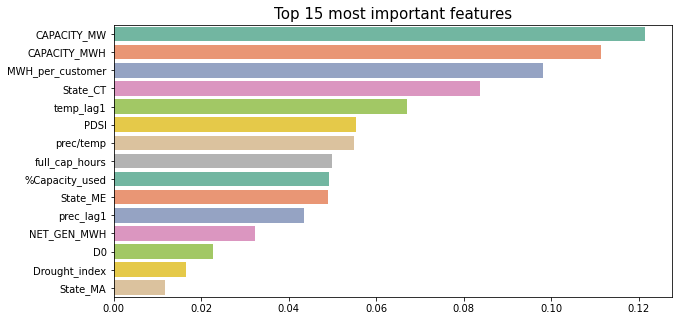

In [ ]:
imp_cv = pd.Series(data=rf_cv.feature_importances_, index=X_test.columns).sort_values(ascending=False)[0:15]
plt.figure(figsize=(10,5))
plt.title("Top 15 most important features", fontsize=15)
ax = sns.barplot(y=imp_cv.index, x=imp_cv.values, palette="Set2", orient='h')

### **Extreme Gradient Boosting:**

In [ ]:
label = df["Price(Cents/kWh)"]
#df.drop(columns=["address","sale price","sale date"],inplace=True)
object_column = df.select_dtypes(include="object")
number_column = df.select_dtypes(exclude="object")
encoder = OrdinalEncoder()
object_column = encoder.fit_transform(object_column)
data = np.concatenate([number_column.values,object_column],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=780)

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'],verbosity = 0, max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    print("The rmse score is:{}".format(rmse))
    print("\n")
    return {'loss': rmse, 'status': STATUS_OK }

trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials);

The rmse score is:2.5959832849232973
The rmse score is:2.595974919125427
The rmse score is:2.5959807426891057
The rmse score is:2.5960026308774244
The rmse score is:2.5959785984588075
The rmse score is:2.5960298062228238
The rmse score is:2.5960002914986604
The rmse score is:2.5960187807962347
The rmse score is:2.5959891123882493
The rmse score is:2.595987496239567
The rmse score is:2.5959749770257967
The rmse score is:2.596027625881458
The rmse score is:2.5960233694570487
The rmse score is:2.5960036222374283
The rmse score is:2.595996219573511
The rmse score is:2.5960029617584626
The rmse score is:2.596014925041686
The rmse score is:2.596018967803396
The rmse score is:2.5959889084273375
The rmse score is:2.5960234548522676
The rmse score is:2.595977855188613
The rmse score is:2.5960051287706523
The rmse score is:2.5960256477709427
The rmse score is:2.595996570053369
The rmse score is:2.5960001720585706
The rmse score is:2.595976675825232
The rmse score is:2.5959749770257967
The rmse s

In [ ]:
best_hyperparams

{'colsample_bytree': 0.9354274406366061,
 'gamma': 1.0493523805937774,
 'max_depth': 17.0,
 'min_child_weight': 2.0,
 'reg_alpha': 123.0,
 'reg_lambda': 0.19217284596715647}

In [ ]:
model_xg =   clf=xgb.XGBRegressor( verbosity=0,
                    max_depth = 10, 
                    gamma = 4.581633341514338,
                    min_child_weight=4,
                    colsample_bytree=0.7299941523366055,
                    reg_alpha = 53.0,
                    reg_lambda = 0.256091424228685
                    )

In [ ]:
model_xg.fit(X_train, y_train)
y_model_xg = model_xg.predict(X_test)

In [ ]:
# XGBoost model evaluation
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_model_xg))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_model_xg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_model_xg)))
print('XGBoost Regression Score:',rf_cv.score(X_test,y_model_xg)*100)

Mean Absolute Error: 1.2913279270420412
Mean Squared Error: 4.310267878769929
Root Mean Squared Error: 2.0761184645318123
XGBoost Regression Score: 66.30219937506725


## Model Interpretation

In [ ]:
pip install shap

In [ ]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

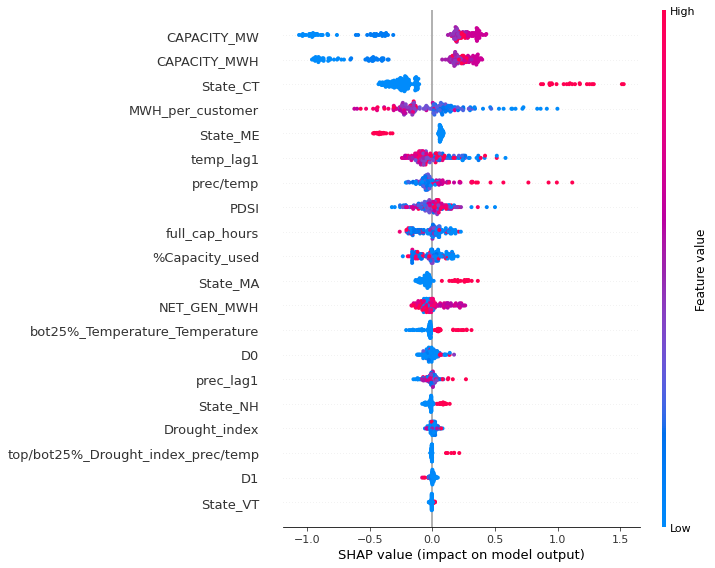

In [ ]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test)

# DATA DICTIONARY : Energy_level.csv
1.   Year: years from 2011 to 2020
2.   Month: month 1-12
3.   State: Northeastern states : Connecticut, Massachusetts, Maine, New Hampshire, New York, Rhode Island and Vermont.
4.   Revenue(Thousand $)：revenue from electricity consumption.
5.   Consumption(Megawatthours): amount of electricity consumed.
6.   Customers(Count): number of customers for each power plant.
7.   Price(Cents/kWh): price of electricity in cents of each kWh unit.
8.   Precipitation: total rainfall depth during a given period in the unit of millimeters (mm).
9.   Temperature: outdoor temperature, measured in degrees Fahrenheit.
10.   Drought_index：Weighted sum of all levels of drought serverity estimates.
11.   D0: indicates abnormal drought condition estimate.
12.   D1: indicates moderate drought condition estimate.
13.   D2: indicates severe drought condition estimate.
14.   D3: indicates extreme drought condition estimate.
15.   D4: indicates exceptional drought condition estimate.
16.   PDSI: Palmer drought severity index that indicates the severity of the departure from normal conditions of the soil water balance and estimates relative soil moisture conditions.
17.   CAPACITY_MW: amount of electricity generators are able to generate.
18.   NET_GEN_MWH: amount of electricity generators actually generate.
19.   CAPACITY_MWH: overall amount of electricity capacity that generators generate.

# DATA DICTIONARY : Plant_level.csv
1. Plant id: plant id.
2. Plant name: plant name.
3. County: located county.
4. State: located state.
5. state_county_fips: Federal Information Processing Standard (FIPS) code which uniquely identifies counties in a State.
5. water_source: EIA-reported name of the plant’s water source for cooling water
7. Latitude: Latitude location of the plant in decimal degrees. 
8. Longitude: Longitude location of the plant in decimal degrees.
9. elevation_in_feet: Elevation of power plant in feet (ft), from sea level, vertical datum WGS84.
10. com_id: USGS NHDPlus Version 1, common identifier (ComID) which is an integer value that uniquely identifies the catchment associated with each plant.
11. gen_type: The generation technology/fuel used to generate electricity.
12. CAPACITY_MW: Total EIA-reported nameplate capacity for water-using generators at each plant in megawatts (MW).
13. CHP: combined heat and power (CHP) plant flag derived from EIA-reported data; 1 = CHP, 0 = Non-CHP 
14. USGS_WATER_TYPE: USGS-assigned cooling water type codes.
15. MODEL_COOL_TYPE: USGS model-assigned cooling-system technology category.
16. MODEL_WD: USGS best estimate of annual water withdrawal in million gallons per day (Mgal/d).
17. MODEL_MIN_WD: USGS model-estimated thermodynamically plausible minimum annual withdrawals in million gallons per day (Mgal/d).
18. MODEL_MAX_WD: USGS model-estimated thermodynamically plausible maximum annual withdrawals in million gallons per day (Mgal/d).
19. EIA_COOL_TYPE: EIA-reported cooling system technology category.
20. EIA_WD: Annual water withdrawal as calculated in million gallons per day (Mgal/d) from EIA. 
21. EIA_WD_INRANGE: Comparison of EIA-reported withdrawal to USGS model-estimated minimum and maximum thermodynamically plausible withdrawal ranges. 
22. COMP_COOL_TYPE: USGS compilation-reported cooling-system technology category.
23. COMP_DATA_SOURCE: USGS-compilation source of thermoelectric withdrawal data.
24. COMP_WD: Plant-specific water withdrawal data in million gallons per day (Mgal/d) provided to this study by USGS Water Science Center.
25. COMP_TOTAL_WD: Plant-specific annual thermoelectric reclaimed wastewater use in million gallons per day (Mgal/d).
26. COMP_WD_INRANGE: Comparison of USGS compilation-reported total water withdrawal to USGS model-estimated thermodynamically plausible minimum and maximum withdrawal ranges.
27. NET_GEN_MWH: amount of electricity generators that actually generated.
28. MAX_WITHDRAWAL: amount of withdrawal water.
29. MIN_CONSUMPTION: minium amount of water consumption.
30. MAX_CONSUMPTION: maximum amount of water consumption.
31. MIN_CONSUMPTION: minium amount of water consumption.
32. Precipitation_1971-2000: total rainfall depth during a given period in the unit of millimeters (mm) from 1971 to 2000.
33. Precipitation_2011 - Precipitation_2021: total rainfall depth during a given period in the unit of millimeters (mm) of each year from 2011 to 2021.
43. Temperature_2011 - Temperature_2021: outdoor temperature, measured in degrees Fahrenheit of each year from 2011 to 2021.